<a href="https://colab.research.google.com/github/AnilOsmanTur/Spatio-Temporal-Event-Prediction/blob/main/Prediction_with_HMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prediction with HMM

In [ ]:
! pip install torcheval
!pip install hmmlearn
import numpy as np
from hmmlearn import hmm
import pandas as pd
# from torcheval.metrics import BinaryAUROC
from sklearn.metrics import roc_curve, auc

np.random.seed(42) # to make the code reproducable
print('imports done')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.5 MB/s eta 0:00:00
imports done


## Data Loading and Splitting

In [ ]:
file_path = "event.csv"
df = pd.read_csv(file_path,header=None)
data = np.array(df.values.tolist())

n_sample = data.shape[0]
flat_data = data.reshape(n_sample, -1)
print('data shape after flattening', flat_data.shape)
n_train = int(0.8 * n_sample )
n_test = n_sample - n_train
train_data = flat_data[:n_train]
test_data = flat_data[n_train:]
print('Training data split', train_data.shape)
print('Testing data split', test_data.shape)

data shape after flattening (408, 50)
Training data split (326, 50)
Testing data split (82, 50)


## Model Training

In [ ]:
# model creation and training
model = hmm.GaussianHMM(n_components=32,
                        covariance_type="full",
                        n_iter=100,
                        verbose=True)
model.fit(train_data)

         1   -4337.39237614             +nan
         2   26602.31595707  +30939.70833321
         3   81775.92260741  +55173.60665034
         4   84131.96335540   +2356.04074799
         5   84236.99873271    +105.03537731
         6   84236.99873271      -0.00000000


GaussianHMM(covariance_type='full', n_components=32, n_iter=100, verbose=True)

## Prediction with model

In [ ]:
# Prediction function to predict next data point
def predict_next(model, known_data):
  state_sequence = model.predict(known_data)
  prob_next_step = model.transmat_[state_sequence[-1], :]
  random_state = np.random.RandomState()
  t1 = model._generate_sample_from_state(np.argmax(prob_next_step),random_state=random_state)
  t1 = 1/(1 + np.exp(-t1)) # sigmoid to get probablity score like resutls
  return t1

In [ ]:
# Distance functions to measure distance between target and prediction
def hamming_dist(a, b):
  return np.count_nonzero(a!=b)
def euclidian_dist(a, b):
  return np.linalg.norm(a-b,1)/len(a)

In [ ]:
t1 = (predict_next(model, train_data[:5]) > 0.5).astype(np.float64)
t1

array([1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.])

In [ ]:
label = train_data[5]
label

array([False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False])

In [ ]:
euclidian_dist(t1, label)

0.78

In [ ]:
hamming_dist(t1, label)

39

In [ ]:
def pra(y_pred,y_true):
  TP = ((y_true == 1) & (y_pred == 1)).sum().item()
  TN = ((y_true == 0) & (y_pred == 0)).sum().item()
  FP = ((y_true == 0) & (y_pred == 1)).sum().item()
  FN = ((y_true == 1) & (y_pred == 0)).sum().item()
  # 정밀도 계산
  precision = TP / (TP + FP) if (TP + FP) > 0 else 0
  # 재현율 계산
  recall = TP / (TP + FN) if (TP + FN) > 0 else 0
  # 정확도 계산
  accuracy = (TP + TN) / (TP + TN + FP + FN)
  return precision,recall,accuracy

## Test Case Generations

In [ ]:
test_idx = np.random.randint(5, n_test, size=100)
start_idx = test_idx-5

In [ ]:

test_cases = [test_data[start:end] for start, end in zip(start_idx,test_idx)]
test_labels = test_data[test_idx]
print(len(test_cases))
print(test_labels.shape)
print(test_cases[0].shape)

100
(100, 50)
(5, 50)


In [ ]:
y_ls = np.array([])
y_hat_ls = np.array([])
for label, a_case in zip(test_labels, test_cases):
  y_hat = predict_next(model,a_case)
  y_hat_ls = np.concatenate((y_hat_ls,y_hat))
  y_ls = np.concatenate((y_ls, label))
print(sum(y_ls==1))
print('prediction done')

736
prediction done


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

[0.49940975 0.51819712 0.49940975 ... 0.51224902 0.62616599 0.50045034]
[0. 0. 0. ... 1. 0. 0.]


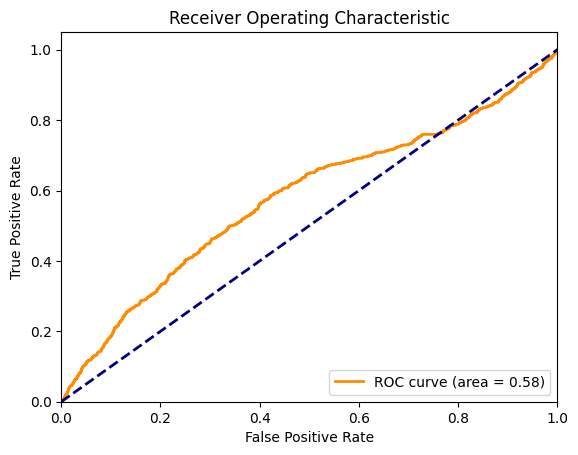

h_dist 5000
e_dist 0.52309107683372
precision 0.2620481927710843
recall 0.11820652173913043
accuracy 0.8212
AUROC 0.5780141120809201


In [ ]:
h_dist = hamming_dist(y_hat_ls,y_ls)
e_dist = euclidian_dist(y_hat_ls,y_ls)
print(y_hat_ls)
print(y_ls)
threshold = 0.7
p,r,a = pra(y_hat_ls>=threshold,y_ls)
fpr, tpr, thresholds = roc_curve(y_ls, y_hat_ls)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
# print("AUROC:", auroc)
print(f"h_dist {h_dist}")
print(f"e_dist {e_dist}")
print(f"precision {p}")
print(f"recall {r}")
print(f"accuracy {a}")
print(f"AUROC {roc_auc}")